In [1]:
%reload_ext autoreload
%autoreload 2

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.util import img_as_float, img_as_ubyte, pad
from skimage.transform import integral_image

import numpy as np

from joblib import Parallel, delayed

from scipy.signal import fftconvolve
from scipy.cluster.hierarchy import fclusterdata
from scipy.spatial.distance import cdist, pdist

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from utilities2015 import *

import os, sys
import cv2
import time

In [2]:
stack = 'MD593'
secind = 100

In [3]:
os.environ['GORDON_DATA_DIR'] = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_processed'
os.environ['GORDON_REPO_DIR'] = '/oasis/projects/nsf/csd395/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_results'

dm = DataManager(data_dir=os.environ['GORDON_DATA_DIR'],
                 repo_dir=os.environ['GORDON_REPO_DIR'],
                 result_dir=os.environ['GORDON_RESULT_DIR'],
                 stack=stack, section=secind)

dm._load_image()

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


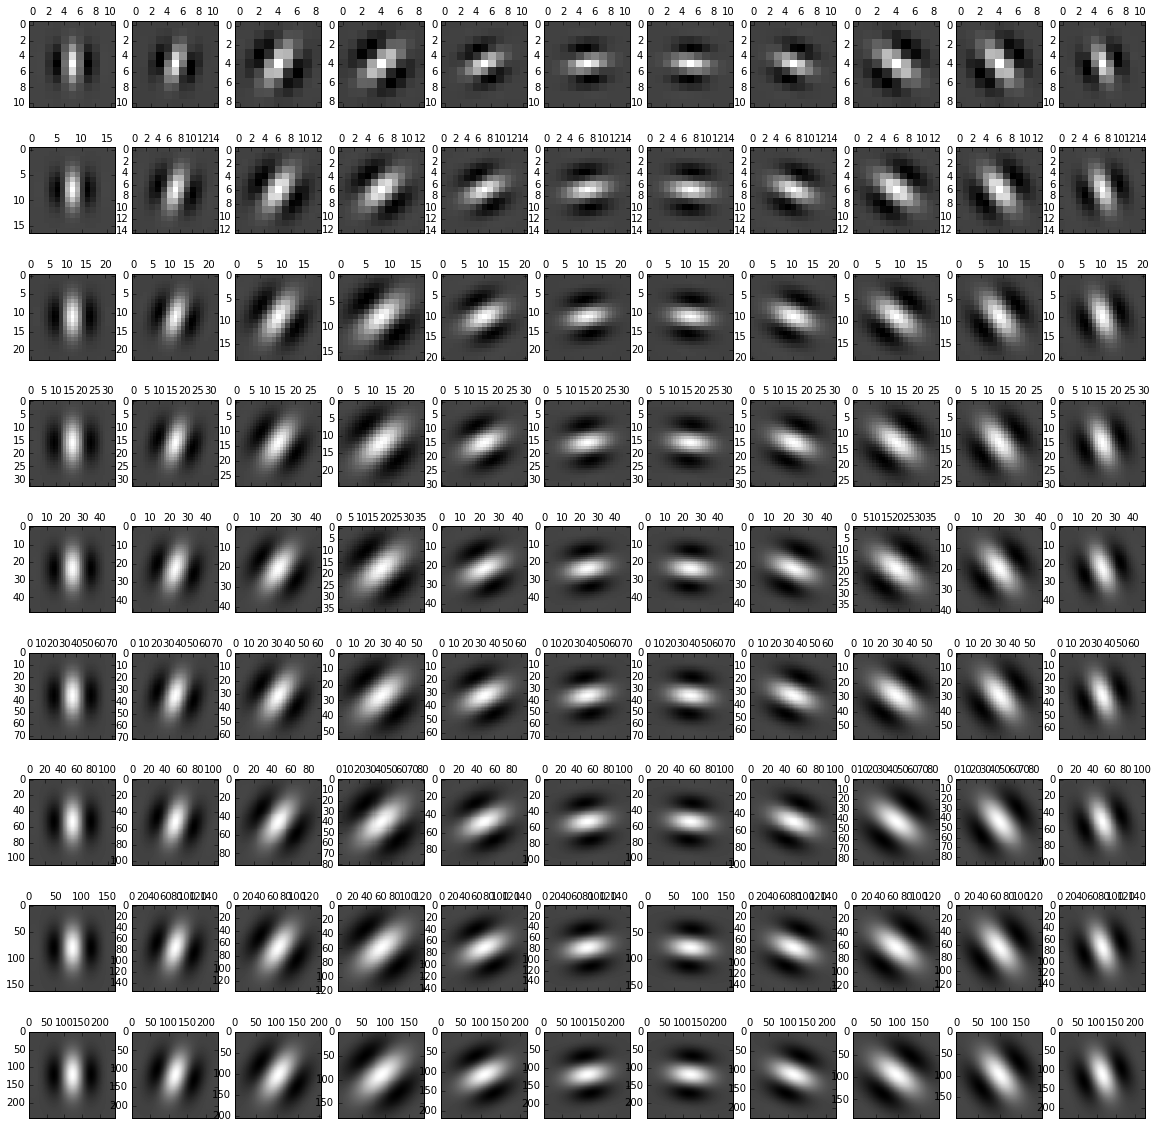

In [6]:
fig, axes = plt.subplots(dm.n_freq, dm.n_angle, figsize=(20,20))

for i, kern in enumerate(dm.kernels):
    r, c = np.unravel_index(i, (dm.n_freq, dm.n_angle))
    axes[r,c].matshow(kern, cmap=plt.cm.gray)
#     axes[r,c].colorbar()

In [4]:
dm.mask = np.zeros_like(dm.image, np.bool)
dm.mask[1848:1848+4807, 924:924+10186] = True

rs, cs = np.where(dm.mask)
ymax = rs.max()
ymin = rs.min()
xmax = cs.max()
xmin = cs.min()
h = ymax-ymin+1
w = xmax-xmin+1

In [5]:
t = time.time()
print 'gabor filtering...',

# im_ub = img_as_ubyte(dm.image)
# approx_bg_intensity = np.argmax(np.bincount(np.r_[im_ub[:10, :10].flat, im_ub[:10, -10:].flat,
#                               im_ub[-10:, :10].flat, im_ub[-10:, -10:].flat], minlength=256))/255.
# padded_image = pad(dm.image, dm.max_kern_size, 'constant', constant_values=approx_bg_intensity)

def convolve_per_proc(i):
#     return fftconvolve(, dm.kernels[i], 'same').astype(np.half)
    pf = fftconvolve(dm.image[ymin-dm.max_kern_size:ymax+1+dm.max_kern_size, 
                              xmin-dm.max_kern_size:xmax+1+dm.max_kern_size], 
                       dm.kernels[i], 'same').astype(np.half)
    sys.stderr.write('filtered kernel %d\n'%i)
    
    return pf[dm.max_kern_size:-dm.max_kern_size, dm.max_kern_size:-dm.max_kern_size]

filtered = Parallel(n_jobs=4)(delayed(convolve_per_proc)(i) for i in range(dm.n_kernel))
features = np.asarray(filtered)

del filtered

print 'done in', time.time() - t, 'seconds'

gabor filtering... done in 231.924257994 seconds


filtered kernel 0
filtered kernel 3
filtered kernel 1
filtered kernel 2
filtered kernel 5
filtered kernel 4
filtered kernel 6
filtered kernel 7
filtered kernel 9
filtered kernel 8
filtered kernel 10
filtered kernel 11
filtered kernel 13
filtered kernel 12
filtered kernel 14
filtered kernel 15
filtered kernel 17
filtered kernel 16
filtered kernel 18
filtered kernel 19
filtered kernel 21
filtered kernel 20
filtered kernel 22
filtered kernel 23
filtered kernel 25
filtered kernel 24
filtered kernel 26
filtered kernel 27
filtered kernel 29
filtered kernel 28
filtered kernel 30
filtered kernel 31
filtered kernel 33
filtered kernel 32
filtered kernel 34
filtered kernel 35
filtered kernel 37
filtered kernel 36
filtered kernel 38
filtered kernel 39
filtered kernel 41
filtered kernel 40
filtered kernel 42
filtered kernel 43
filtered kernel 45
filtered kernel 44
filtered kernel 46
filtered kernel 47
filtered kernel 49
filtered kernel 48
filtered kernel 50
filtered kernel 51
filtered kernel 53
fil

In [54]:
# f = filtered[90]
# display(plt.cm.jet(f/np.abs(f).max()))

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [6]:
def rotate_features(fs):
    features_tabular = fs.reshape((fs.shape[0], dm.n_freq, dm.n_angle))
    max_angle_indices = features_tabular.max(axis=1).argmax(axis=-1)
    features_rotated = np.reshape([np.roll(features_tabular[i], -ai, axis=-1) 
                               for i, ai in enumerate(max_angle_indices)], (fs.shape[0], dm.n_freq * dm.n_angle))
    
    return features_rotated
    
#     return features_rotated, max_angle_indices

t = time.time()
print 'rotate features ...',

n_splits = 1000
# features_rotated_tuple_list = Parallel(n_jobs=16)(delayed(rotate_features)(fs) 
#                                                   for fs in np.array_split(features.reshape((99,-1)).T, n_splits))
# features_rotated = np.vstack([fr for fr, mai in features_rotated_tuple_list])

features_rotated = Parallel(n_jobs=16)(delayed(rotate_features)(fs) 
                           for fs in np.array_split(features.reshape((dm.n_kernel,-1)).T, n_splits))

features_rotated = np.vstack(features_rotated)

print 'done in', time.time() - t, 'seconds'

# del features_rotated_tuple_list

rotate features ... done in 214.201962948 seconds


In [10]:
t = time.time()
print 'saving features data ...',

# dm.save_pipeline_result(features_rotated, 'featuresRotated', 'npy')
dm.save_pipeline_result(features_rotated, 'featuresRotated', 'hdf')

print 'done in', time.time() - t, 'seconds'

saving features data ... saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0100/MD593_0100_lossless_warped_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_featuresRotated.npy
done in 27.0010721684 seconds


In [179]:
from networkx import from_dict_of_lists, dfs_postorder_nodes

In [177]:
# neighbors = dm.load_pipeline_result('neighbors', 'pkl')
neighbors_global = neighbors

# sp_properties = dm.load_pipeline_result('spProps', 'npy')
# # each item is (center_y, center_x, area, mean_intensity, ymin, xmin, ymax, xmax)
# segmentation_vis = dm.load_pipeline_result('segmentationWithoutText', 'jpg')

# try:
#     sp_sp_dists = dm.load_pipeline_result('texHistPairwiseDist', 'npy')
# #     raise
# except:

# def f(a):
#     sp_dists = cdist(a, texton_hists, metric=chi2)
# #         sp_dists = cdist(a, texton_hists, metric=js)
#     return sp_dists

# sp_dists = Parallel(n_jobs=16)(delayed(f)(s) for s in np.array_split(texton_hists, 16))
# sp_sp_dists = np.vstack(sp_dists)

# dm.save_pipeline_result(sp_sp_dists, 'texHistPairwiseDist', 'npy')

# center_dists = pdist(sp_properties[:, :2])
# center_dist_matrix = squareform(center_dists)

neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
neighbor_graph = from_dict_of_lists(neighbors_dict)


# try:
#     expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
# #         raise
# except Exception as e:

grow cluster ... An unexpected error occurred while tokenizing input file /oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/joblib/parallel.pyc
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line statement', (287, 0))
 An unexpected error occurred while tokenizing input file /oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/joblib/parallel.pyc
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line statement', (287, 0))
 An unexpected error occurred while tokenizing input file /oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/joblib/parallel.pyc
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line statement', (287, 0))
 An unexpected error occurred while tokenizing input file /oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.

KeyboardInterrupt: 

In [196]:
print 'grow cluster ...',
b = time.time()

# Observation: if `neighbors` is passed as argument, execution takes 4.5 times than if `neighbors` is global
# Reason: `neighbors` is a list of sets, not mem-mappable. To see the error, run the lines below:
# from joblib import load, dump
# _ = dump(neighbors, '/tmp/tmp')
# large_memmap = load('/tmp/tmp', mmap_mode='r+')
# Solution: make `neighbors` global
# p.s. if CPU utilizations of many processes are low, it means IO is taking much of the time
# p.s. specify max_nbytes argument to Parallel enables memmap for shared variables, but using it results in 
# error `zero-dimensional array concatenates...`

# for s in range(n_superpixels):
#     ect = grow_cluster3(s, texton_hists=texton_hists)
    
ect = grow_cluster3(15530, texton_hists=texton_hists, all_history=True)

# expansion_clusters_tuples = Parallel(n_jobs=16)(delayed(grow_cluster3)(s, texton_hists=texton_hists)
#                                                             )

print 'done in', time.time() - b, 'seconds'

# dm.save_pipeline_result(expansion_clusters_tuples, 'clusters', 'pkl')

# expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)

grow cluster ... done in 8.80896615982 seconds


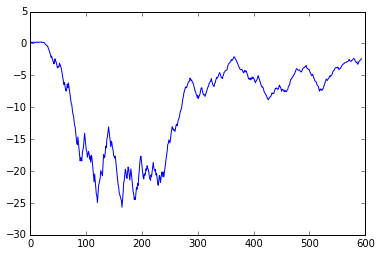

In [200]:
plt.plot(ect[3][:,1])

In [203]:
segmentation_vis = dm.load_pipeline_result('segmentationWithoutText', 'jpg')

In [206]:
display(dm.visualize_cluster(ect[0], bg=segmentation_vis[ymin:ymax+1, xmin:xmax+1]))

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [173]:
def find_boundary_sps(clusters, neighbors, neighbor_graph, mode='both'):
    '''
    Identify superpixels that are at the boundary of regions: surround set and frontier set
    
    Parameters
    ----------
    clusters : list of integer lists
    neighbors : neighbor_list
    neighbor_graph : 
    '''
        
    n_superpixels = len(clusters)
    
    surrounds_sps = []
    frontiers_sps = []
    
    for cluster_ind, cluster in enumerate(clusters):
        
        surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
#         surrounds = set([i for i in surrounds if any([(n not in cluster) and (n not in surrounds) for n in neighbors[i]])])
        surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

        if len(surrounds) == 0:
            surrounds_sps.append([])
            frontiers_sps.append([])
        else:
            if mode == 'surround' or mode == 'both':
                surrounds_subgraph = neighbor_graph.subgraph(surrounds)
                surrounds_traversal = list(dfs_postorder_nodes(surrounds_subgraph))
                surrounds_sps.append(surrounds_traversal)

            if mode == 'frontier' or mode == 'both':
                frontiers = set.union(*[neighbors[c] for c in surrounds]) & set(cluster)
                frontiers_subgraph = neighbor_graph.subgraph(frontiers)
                frontiers_traversal = list(dfs_postorder_nodes(frontiers_subgraph))
                frontiers_sps.append(frontiers_traversal)
    
    if mode == 'frontier':
        return frontiers_sps
    elif mode == 'surround':
        return surrounds_sps
    elif mode == 'both':
        return surrounds_sps, frontiers_sps


def compute_cluster_score(cluster, texton_hists, neighbors):
    
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)
    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    if len(surrounds) == 0: # single sp on background
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    surrounds_list = list(surrounds)
    surround_dist = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], chi2)).min()

    surds, _ = find_boundary_sps([cluster], neighbors=neighbors, neighbor_graph=neighbor_graph)
    
    compactness = len(surds[0])**2/float(len(cluster))
    compactness = .001 * np.maximum(compactness-40,0)**2
    
    size_prior = .1 * (1-np.exp(-.8*len(cluster)))
    
    score = surround_dist - compactness + size_prior
    
    interior_dist = np.nan
    interior_pval = np.nan
    surround_pval = np.nan
    
    return score, surround_dist, interior_dist, compactness, surround_pval, interior_pval, size_prior


neighbors_global = None

def grow_cluster3(seed, texton_hists, neighbors=None, output=False, all_history=False):
    
    if neighbors is None:
        neighbors = neighbors_global
    
    visited = set([])
    curr_cluster = set([])
        
    candidate_scores = [0]
    candidate_sps = [seed]

    score_tuples = []
    added_sps = []
    
    iter_ind = 0
        
    while len(candidate_sps) > 0:

        best_ind = np.argmax(candidate_scores)
        
        heuristic = candidate_scores[best_ind]
        sp = candidate_sps[best_ind]
        
        del candidate_scores[best_ind]
        del candidate_sps[best_ind]
        
        if sp in curr_cluster:
            continue
                
        iter_ind += 1
        curr_cluster.add(sp)
        added_sps.append(sp)
        
        tt = compute_cluster_score(curr_cluster, texton_hists=texton_hists, neighbors=neighbors)
        tot, exterior, interior, compactness, surround_pval, interior_pval, size_prior = tt
        if np.isnan(tot):
            return [seed], -np.inf
        score_tuples.append(np.r_[heuristic, tt])
        
        if output:
            print 'iter', iter_ind, 'add', sp

        visited.add(sp)
        
        candidate_sps = (set(candidate_sps) | (neighbors[sp] - set([-1])) | (visited - curr_cluster)) - curr_cluster
        candidate_sps = list(candidate_sps)
        
#         f_avg = texton_freqs[list(curr_cluster)].sum(axis=0)
#         candidate_scores = [chi2pval(f_avg, texton_freqs[i])[0] for i in candidate_sps]

        h_avg = texton_hists[list(curr_cluster)].mean(axis=0)
        candidate_scores = [-chi2(h_avg, texton_hists[i]) for i in candidate_sps]

#         candidate_scores = [compute_cluster_score(curr_cluster | set([s])) for s in candidate_sps]
                
        if len(visited) > int(n_superpixels * 0.03):
            break

    score_tuples = np.array(score_tuples)
    
    min_size = 2
    scores = score_tuples[:,1]
    cutoff = np.argmax(scores[min_size:]) + min_size
    
    if output:
        print 'cutoff', cutoff

    final_cluster = added_sps[:cutoff]
    final_score = scores[cutoff]
    
    if all_history:
        return list(final_cluster), final_score, added_sps, score_tuples
    else:
        return list(final_cluster), final_score